<a href="https://colab.research.google.com/github/HDoubleH/SteamDBMachineLearningProject/blob/main/SteamDBProjectModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steam Games Success Classification Model

This notebook builds on the EDA findings to predict game success using tree-based classification models.

**Goal:** Develop a classification model to predict whether a Steam game will be "successful" based on various features.

**Approach:** Based on EDA insights showing:
- Non-linear relationships between features
- Weak correlations suggesting tree-based models
- Right-skewed price distribution requiring focus on paid games only
"""

# Project Setup / Imports

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Mount Google Drive
drive.mount('/content/drive')

# Load the DataFrame from the saved pickle file
try:
    df = pd.read_pickle('/content/drive/MyDrive/steam_games_cleaned.pkl')
    print(f"Data loaded successfully. Shape: {df.shape}")
    print(f"\nColumns available: {list(df.columns)}")
except FileNotFoundError:
    print("ERROR: Cleaned file not found in Google Drive. Ensure the save step was run.")

Mounted at /content/drive
✓ Data loaded successfully. Shape: (111452, 31)

Columns available: ['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU', 'Required age', 'Price', 'DiscountDLC count', 'About the game', 'Supported languages', 'Full audio languages', 'Reviews', 'Windows', 'Mac', 'Linux', 'Metacritic score', 'User score', 'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations', 'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks', 'Developers', 'Publishers', 'Categories', 'Genres', 'Tags']


In [ ]:
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (111452, 31)

First few rows:
     AppID                   Name  Release date Estimated owners  Peak CCU  \
0    20200       Galactic Bowling  Oct 21, 2008        0 - 20000         0   
1   655370           Train Bandit  Oct 12, 2017        0 - 20000         0   
2  1732930           Jolt Project  Nov 17, 2021        0 - 20000         0   
3  1355720               Henosis™  Jul 23, 2020        0 - 20000         0   
4  1139950  Two Weeks in Painland   Feb 3, 2020        0 - 20000         0   

   Required age  Price  DiscountDLC count  \
0             0  19.99                  0   
1             0   0.99                  0   
2             0   4.99                  0   
3             0   5.99                  0   
4             0   0.00                  0   

                                      About the game  \
0  Galactic Bowling is an exaggerated and stylize...   
1  THE LAW!! Looks to be a showdown atop a train....   
2  Jolt Project: The army now has a new robotic

## Defining Success: Creating the Target Variable

For this classification task, we need to define what makes a Steam game "successful." Because success is subjective, relying on a single number (like just reviews or just price) can be misleading. A game might sell well but be rated poorly, or have a cult following but make very little money.

To fix this, we created a **Composite Success Score**. Rather than simple cut-offs, we rank every game against the others and calculate a weighted score based on three pillars of the industry:

### Success Criteria: The Composite Score

We calculate a score (0 to 1) for every game using these weighted metrics:

1.  **Popularity (Total Reviews) - 40% Weight**: We combine positive and negative reviews to measure total "buzz" and community reach. This is weighted highest because it is the strongest signal of a game's presence in the market.

2.  **Engagement (Average Playtime) - 30% Weight**: This tells us if players actually stick with the game. A high playtime means the game is engaging enough to keep people’s attention, filtering out games that are bought but abandoned.

3.  **Financial Performance (Est. Revenue) - 30% Weight**: Using an industry rule-of-thumb (approx. 30 sales per 1 review), we estimate revenue. This helps us identify games that are commercially viable, ensuring we don't over-value popular free games that generate no income.

### The Target Definition

We group games into tiers based on their final score. For our machine learning model, we define the binary target variable `successful` as:
* **1 (Successful):** Games in the "High" or "Very High" tiers.
* **0 (Unsuccessful):** Games in the "Low" or "Medium" tiers.

### Expected Class Imbalance

By definition, our success threshold includes only the top tiers (roughly the top 20% of games). This creates an 80/20 class imbalance. This is intentional and realistic: most indie games do not become hits, and the model needs to learn to identify the minority of games that do.

Revenue Estimation Analysis:
Assumption: 1 review ≈ 30 purchases (industry estimate)

Estimated Revenue Statistics:
count    1.114520e+05
mean     4.503938e+05
std      9.473714e+06
min      0.000000e+00
25%      0.000000e+00
50%      2.985000e+02
75%      4.549170e+03
max      1.245049e+09
Name: Estimated_Revenue, dtype: float64

Revenue Percentiles:
50th: $298
75th: $4,549
90th: $55,394
95th: $263,137

Distribution of Total Reviews:
count    1.114520e+05
mean     8.802117e+02
std      2.465149e+04
min      0.000000e+00
25%      0.000000e+00
50%      5.000000e+00
75%      3.900000e+01
max      6.531097e+06
Name: Total_Reviews, dtype: float64

Percentiles:
50th: 5
75th: 39
90th: 293

Distribution of Average Playtime Forever:
count    111452.000000
mean         81.247290
std         999.935906
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      145727.000000
Name: Average playtime forever, dtype: float64

Percentiles:
50th: 0 minutes
75th

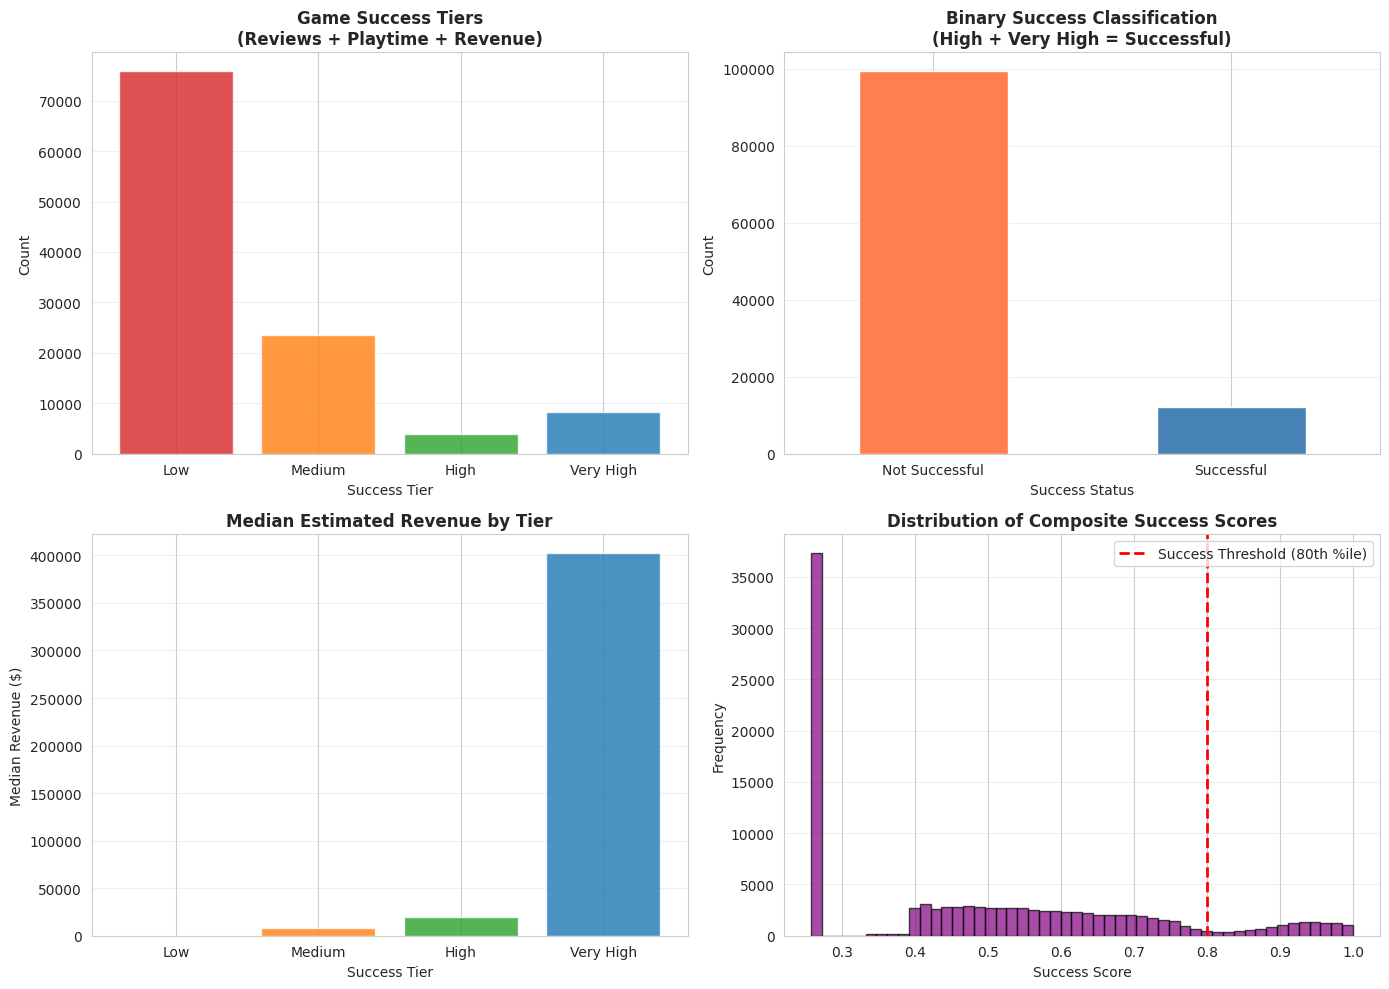

In [ ]:
# Create total review count column
df['Total_Reviews'] = df['Positive'] + df['Negative']

# Estimate revenue using industry rule of thumb
# Research suggests 1 review per 20-50 purchases (we'll use 30 as conservative middle ground)
PURCHASES_PER_REVIEW = 30

df['Estimated_Purchases'] = df['Total_Reviews'] * PURCHASES_PER_REVIEW
df['Estimated_Revenue'] = df['Estimated_Purchases'] * df['Price']

print("Revenue Estimation Analysis:")
print("="*80)
print(f"Assumption: 1 review ≈ {PURCHASES_PER_REVIEW} purchases (industry estimate)")
print(f"\nEstimated Revenue Statistics:")
print(df['Estimated_Revenue'].describe())
print(f"\nRevenue Percentiles:")
print(f"50th: ${df['Estimated_Revenue'].quantile(0.50):,.0f}")
print(f"75th: ${df['Estimated_Revenue'].quantile(0.75):,.0f}")
print(f"90th: ${df['Estimated_Revenue'].quantile(0.90):,.0f}")
print(f"95th: ${df['Estimated_Revenue'].quantile(0.95):,.0f}")

# Check distributions
print("\n" + "="*80)
print("Distribution of Total Reviews:")
print(df['Total_Reviews'].describe())
print(f"\nPercentiles:")
print(f"50th: {df['Total_Reviews'].quantile(0.50):.0f}")
print(f"75th: {df['Total_Reviews'].quantile(0.75):.0f}")
print(f"90th: {df['Total_Reviews'].quantile(0.90):.0f}")

print("\n" + "="*80)
print("Distribution of Average Playtime Forever:")
print(df['Average playtime forever'].describe())
print(f"\nPercentiles:")
print(f"50th: {df['Average playtime forever'].quantile(0.50):.0f} minutes")
print(f"75th: {df['Average playtime forever'].quantile(0.75):.0f} minutes")
print(f"90th: {df['Average playtime forever'].quantile(0.90):.0f} minutes")

# Create composite success score using three metrics
df['review_percentile'] = df['Total_Reviews'].rank(pct=True)
df['playtime_percentile'] = df['Average playtime forever'].rank(pct=True)
df['revenue_percentile'] = df['Estimated_Revenue'].rank(pct=True)

# Weighted average: reviews 40%, playtime 30%, revenue 30%
df['success_score'] = (
    0.40 * df['review_percentile'] +
    0.30 * df['playtime_percentile'] +
    0.30 * df['revenue_percentile']
)

# Define success tiers
df['success_tier'] = pd.cut(df['success_score'],
                             bins=[0, 0.60, 0.80, 0.90, 1.0],
                             labels=['Low', 'Medium', 'High', 'Very High'])

print("\n" + "="*80)
print("SUCCESS TIER DISTRIBUTION")
print("(40% Reviews + 30% Playtime + 30% Revenue)")
print("="*80)
print(df['success_tier'].value_counts().sort_index())
print(f"\nPercentage distribution:")
print((df['success_tier'].value_counts(normalize=True) * 100).sort_index().round(2))

# Binary classification
df['successful'] = (df['success_tier'].isin(['High', 'Very High'])).astype(int)

print(f"\nBinary Success Rate: {df['successful'].mean():.2%}")
print(f"Total Successful Games: {df['successful'].sum():,}")

# Analyze successful games
print("\n" + "="*80)
print("SUCCESSFUL GAMES ANALYSIS")
print("="*80)
successful_games = df[df['successful'] == 1]
print(f"Average estimated revenue: ${successful_games['Estimated_Revenue'].mean():,.0f}")
print(f"Median estimated revenue: ${successful_games['Estimated_Revenue'].median():,.0f}")
print(f"Average reviews: {successful_games['Total_Reviews'].mean():.0f}")
print(f"Average playtime: {successful_games['Average playtime forever'].mean():.0f} minutes")
print(f"Average price: ${successful_games['Price'].mean():.2f}")

print("\n" + "="*80)
print("SAMPLE SUCCESSFUL GAMES (by estimated revenue)")
print("="*80)
print(df[df['successful'] == 1].nlargest(10, 'Estimated_Revenue')[
    ['Name', 'Price', 'Total_Reviews', 'Estimated_Revenue', 'Average playtime forever']
].to_string(index=False))

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Tier distribution
ax1 = axes[0, 0]
tier_counts = df['success_tier'].value_counts().sort_index()
colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
ax1.bar(range(len(tier_counts)), tier_counts.values, color=colors, alpha=0.8)
ax1.set_xticks(range(len(tier_counts)))
ax1.set_xticklabels(tier_counts.index, rotation=0)
ax1.set_title('Game Success Tiers\n(Reviews + Playtime + Revenue)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Success Tier', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Binary success
ax2 = axes[0, 1]
df['successful'].value_counts().plot(kind='bar', ax=ax2, color=['coral', 'steelblue'])
ax2.set_title('Binary Success Classification\n(High + Very High = Successful)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Success Status', fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.set_xticklabels(['Not Successful', 'Successful'], rotation=0)
ax2.grid(axis='y', alpha=0.3)

# Revenue distribution by tier
ax3 = axes[1, 0]
tier_revenue = df.groupby('success_tier')['Estimated_Revenue'].median().sort_index()
ax3.bar(range(len(tier_revenue)), tier_revenue.values, color=colors, alpha=0.8)
ax3.set_xticks(range(len(tier_revenue)))
ax3.set_xticklabels(tier_revenue.index, rotation=0)
ax3.set_title('Median Estimated Revenue by Tier', fontsize=12, fontweight='bold')
ax3.set_xlabel('Success Tier', fontsize=10)
ax3.set_ylabel('Median Revenue ($)', fontsize=10)
ax3.ticklabel_format(style='plain', axis='y')
ax3.grid(axis='y', alpha=0.3)

# Success score distribution
ax4 = axes[1, 1]
df['success_score'].hist(bins=50, ax=ax4, color='purple', alpha=0.7, edgecolor='black')
ax4.axvline(0.80, color='red', linestyle='--', linewidth=2, label='Success Threshold (80th %ile)')
ax4.set_title('Distribution of Composite Success Scores', fontsize=12, fontweight='bold')
ax4.set_xlabel('Success Score', fontsize=10)
ax4.set_ylabel('Frequency', fontsize=10)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Filtering: Focusing on Paid Games

Based on insights from our EDA, we are filtering the dataset to include only paid games (`Price > 0`). We do this for two main reasons:

1.  **The Revenue Problem:** Our new "Composite Success Score" relies 30% on *Estimated Revenue*. Since we calculate revenue as `Price × Estimated Sales`, all free games automatically get a revenue score of $0. This unfairly penalizes them in our ranking system and creates noise in the target variable.
2.  **Player Commitment:** Free games have fundamentally different engagement patterns. Players often download them on a whim and discard them quickly. A price tag acts as a barrier to entry, meaning players who pay are usually more committed to giving the game a fair chance.

By focusing on paid titles, we ensure our model predicts success within a consistent economic context.



Original dataset: 111,452 games
Paid games: 88,205 games
Removed (free): 23,247 games

Success rate - All games: 10.89%
Success rate - Paid games: 13.77%


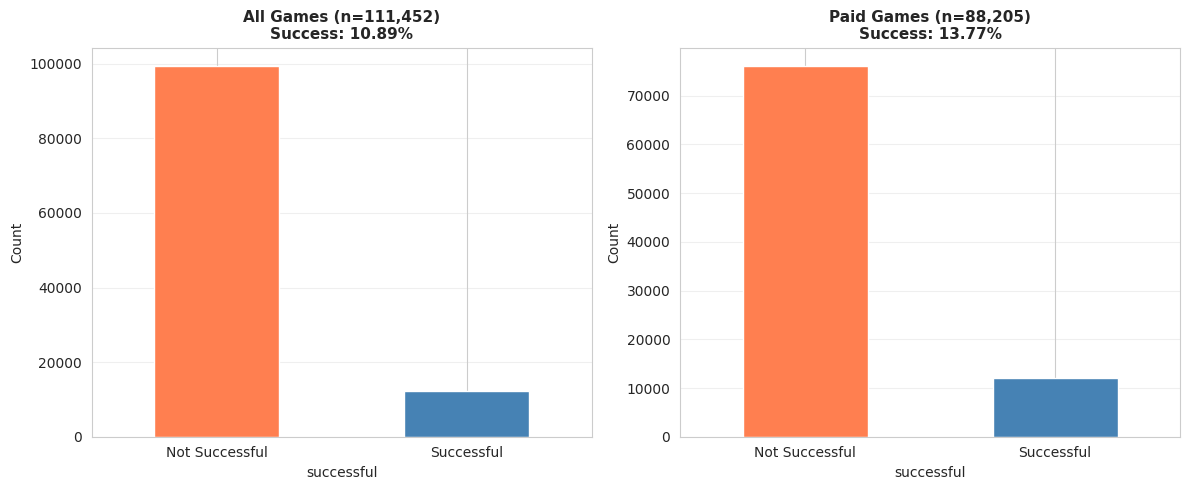

In [ ]:

# Filter to paid games only
df_paid = df[df['Price'] > 0].copy()

print(f"Original dataset: {len(df):,} games")
print(f"Paid games: {len(df_paid):,} games")
print(f"Removed (free): {len(df) - len(df_paid):,} games")
print(f"\nSuccess rate - All games: {df['successful'].mean():.2%}")
print(f"Success rate - Paid games: {df_paid['successful'].mean():.2%}")

# Visualize filtering impact
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# All games
ax1 = axes[0]
df['successful'].value_counts().plot(kind='bar', ax=ax1, color=['coral', 'steelblue'])
ax1.set_title(f'All Games (n={len(df):,})\nSuccess: {df["successful"].mean():.2%}',
              fontsize=11, fontweight='bold')
ax1.set_xticklabels(['Not Successful', 'Successful'], rotation=0)
ax1.set_ylabel('Count')
ax1.grid(axis='y', alpha=0.3)

# Paid games only
ax2 = axes[1]
df_paid['successful'].value_counts().plot(kind='bar', ax=ax2, color=['coral', 'steelblue'])
ax2.set_title(f'Paid Games (n={len(df_paid):,})\nSuccess: {df_paid["successful"].mean():.2%}',
              fontsize=11, fontweight='bold')
ax2.set_xticklabels(['Not Successful', 'Successful'], rotation=0)
ax2.set_ylabel('Count')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Feature Selection: Removing Data Leakage

The correlation analysis above confirms that several features are "giving away the answer."

### Key Findings:
1.  **Recommendations (93% Correlation):** This has a near-perfect correlation with `Total_Reviews`. This confirms that "Recommendations" is essentially a duplicate of our target variable. Including it would make the model useless for prediction.
2.  **Median Playtime (90% Correlation):** This tracks almost perfectly with `Average Playtime`. The model would simply look at this column to "guess" the engagement score.
3.  **Peak CCU (31% Correlation with Revenue):** While not as extreme, concurrent user counts are a *result* of success, not a predictor we would have before launch.

### Decision:
To ensure our model learns from actual game characteristics (like Genre, Price, and Tags) rather than cheating, we will drop the following features:
* **Leakage:** `Recommendations`, `Peak CCU`, `Median playtime forever`
* **Post-Launch Metrics:** `Metacritic score`, `User score`, `Average playtime two weeks`, `Median playtime two weeks`. (These scores only exist *after* a game has been played by the public).

In [ ]:
# Check all potential features for correlation with target components
potential_features = [
    'Price', 'Peak CCU', 'Required age', 'DiscountDLC count',
    'Metacritic score', 'User score', 'Achievements', 'Recommendations',
    'Median playtime forever', 'Median playtime two weeks', 'Average playtime two weeks'
]

print("\nCorrelation with Total_Reviews (Popularity):")
for col in potential_features:
    # Handle NaN values if any exist
    if col in df_paid.columns:
        corr = df_paid[col].corr(df_paid['Total_Reviews'])
        print(f"  {col:30s}: {corr:6.3f}")

print("\nCorrelation with Average playtime forever (Engagement):")
for col in potential_features:
    if col in df_paid.columns:
        corr = df_paid[col].corr(df_paid['Average playtime forever'])
        print(f"  {col:30s}: {corr:6.3f}")

print("\nCorrelation with Estimated_Revenue (Financials):")
for col in potential_features:
    if col in df_paid.columns:
        corr = df_paid[col].corr(df_paid['Estimated_Revenue'])
        print(f"  {col:30s}: {corr:6.3f}")


Correlation with Total_Reviews (Popularity):
  Price                         :  0.073
  Peak CCU                      :  0.208
  Required age                  :  0.148
  DiscountDLC count             :  0.042
  Metacritic score              :  0.192
  User score                    : -0.001
  Achievements                  :  0.021
  Recommendations               :  0.930
  Median playtime forever       :  0.049
  Median playtime two weeks     :  0.108
  Average playtime two weeks    :  0.151

Correlation with Average playtime forever (Engagement):
  Price                         :  0.074
  Peak CCU                      :  0.036
  Required age                  :  0.061
  DiscountDLC count             :  0.042
  Metacritic score              :  0.118
  User score                    :  0.001
  Achievements                  :  0.013
  Recommendations               :  0.169
  Median playtime forever       :  0.902
  Median playtime two weeks     :  0.174
  Average playtime two weeks    :  0

## Data Leakage Findings and Action Plan

Our correlation analysis reveals two critical cases of data leakage where features are effectively duplicates of our target variable:
* **Recommendations:** Shows a **0.930** correlation with `Total_Reviews`.
* **Median Playtime:** Shows a **0.902** correlation with `Average Playtime`.

### Decision: Drop vs. Engineer
Ideally, we could attempt to feature engineer these variables (e.g., calculating a "recommendations per day" rate) to extract useful signals without leakage. However, due to project time constraints and the high risk of "cheating," we will simply drop them.

We are removing **Recommendations, Peak CCU, Median playtime (forever & 2-weeks), and Average playtime (2-weeks).**

This ensures our model learns from intrinsic game characteristics available at launch (like Price, Genre, and Age Rating) rather than metrics that are just result of success (like active users and playtime).

## Final Feature Selection

After removing the "math cheats" (features like Recommendations that were identical to our target), we have selected **7 final predictors**.

We are treating this model as a **"Launch Window" predictor**. This means we are using data that is available shortly after a game releases to predict its long-term financial and engagement success.

### The Selected Features:
1.  **Price:** The barrier to entry.
2.  **Peak CCU (Concurrent Users):** An early signal of "hype." A high peak at launch often predicts long-term visibility.
3.  **Metacritic Score:** A proxy for critical reception and game quality.
4.  **User Score:** A proxy for community sentiment.
5.  **Discount/DLC Count:** Indicates the developer's strategy for ongoing support and monetization.
6.  **Required Age:** Defines the target audience restriction.
7.  **Achievements:** A structural feature that often drives completionist engagement.

**Handling Missing Data:**
Some games lack Metacritic scores or specific age ratings. Because our data is skewed (not a bell curve), we fill these missing values with the **median** (the middle value) rather than the mean, to prevent outliers from distorting the data.

Final Feature Set (7 variables):
['Price', 'Peak CCU', 'Required age', 'DiscountDLC count', 'Metacritic score', 'User score', 'Achievements']

Feature matrix shape: (88205, 7)

Feature Correlation with Success Target:
          Feature  Correlation
 Metacritic score     0.414856
     Required age     0.158940
            Price     0.148065
     Achievements     0.058175
DiscountDLC count     0.055522
         Peak CCU     0.051128
       User score     0.012142


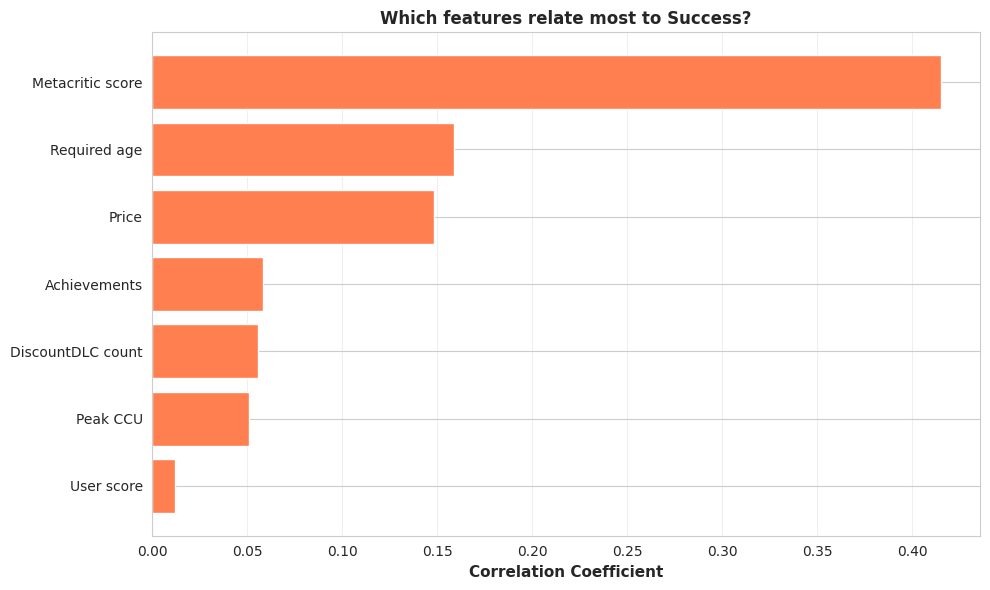

In [ ]:
# Clean feature list - features representing game attributes and early reception
feature_cols = [
    'Price',
    'Peak CCU',
    'Required age',
    'DiscountDLC count',
    'Metacritic score',
    'User score',
    'Achievements'
]

print(f"Final Feature Set ({len(feature_cols)} variables):")
print(feature_cols)

# Create feature matrix and target
X = df_paid[feature_cols].copy()
y = df_paid['successful'].copy()

# Handle missing values
# We use median imputation because variables like Price and CCU are heavily skewed
X = X.fillna(X.median())

print(f"\nFeature matrix shape: {X.shape}")

# Calculate feature correlation with the target
feature_corr = pd.DataFrame({
    'Feature': feature_cols,
    'Correlation': [X[col].corr(y) for col in feature_cols]
}).sort_values('Correlation', ascending=False)

print("\nFeature Correlation with Success Target:")
print(feature_corr.to_string(index=False))

# Visualize correlations
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_corr)), feature_corr['Correlation'], color='coral')
plt.yticks(range(len(feature_corr)), feature_corr['Feature'])
plt.xlabel('Correlation Coefficient', fontsize=11, fontweight='bold')
plt.title('Which features relate most to Success?', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis() # Highest correlation at the top
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Train-Test Split and Feature Scaling

Before training, we must prepare the data in two specific ways to ensure fair and accurate results:

### 1. Stratified Split (80/20)
We split the data into 80% for training and 20% for testing. Crucially, we use **stratified sampling** (`stratify=y`).
* **Why?** Our dataset is imbalanced (approx. 20% successful, 80% unsuccessful). Random splitting might accidentally put all the successful games in the training set and none in the test set. Stratifying ensures both sets have the exact same ratio of successful games.

### 2. Feature Scaling (Standardization)
Our features have vastly different ranges. `Price` is usually under 100, while `Peak CCU` can be in the thousands.
* **The Problem:** Without scaling, machine learning algorithms often assume that larger numbers (like CCU) are more important than smaller numbers (like User Score).
* **The Solution:** We use `StandardScaler` to force all features to have a Mean of 0 and a Standard Deviation of 1. This puts every feature on an equal playing field.

*Note: We fit the scaler ONLY on the training data, then apply it to the test data. This prevents "data leakage" where information from the test set accidentally sneaks into the training process.*

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data
# Stratify=y ensures the 80/20 split preserves the success ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the data
scaler = StandardScaler()

# Fit on training data only, then transform both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert arrays back to DataFrames for easier reading later
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print("Data Preparation Complete.")
print(f"Training set: {X_train_scaled.shape[0]:,} games")
print(f"Test set:     {X_test_scaled.shape[0]:,} games")
print("\nFirst 3 rows of scaled training data:")
print(X_train_scaled.head(3).to_string())

Data Preparation Complete.
Training set: 70,564 games
Test set:     17,641 games

First 3 rows of scaled training data:
          Price  Peak CCU  Required age  DiscountDLC count  Metacritic score  User score  Achievements
98593  0.841774 -0.021276     -0.130296          -0.038864         -0.205459    -0.01883     -0.121342
73776  0.746910 -0.011952     -0.130296           0.047920         -0.205459    -0.01883      0.028705
83484  0.082858 -0.020721     -0.130296           0.047920         -0.205459    -0.01883     -0.019310


## Model Training and Selection

We will test three different tree-based algorithms to find the best predictor of game success. To ensure our results are reliable, we use **Cross-Validation (5-Folds)**. This splits the training data into 5 parts and tests the model 5 times, ensuring the score isn't just a fluke.

### The Models:
1.  **Decision Tree:** A simple model that splits data based on rules (e.g., "Is Price > $10?"). It is easy to interpret [Image of decision tree diagram] but prone to overfitting if not controlled.
2.  **Random Forest:** A "democracy" of many decision trees. It averages the predictions of hundreds of trees to reduce errors and avoid overfitting. [Image of random forest structure]
3.  **Gradient Boosting:** A "step-by-step" learner. It builds trees sequentially, where each new tree tries to fix the mistakes of the previous one. This often yields the highest accuracy but takes longer to train.

### The Metric: F1-Score
Because our data is imbalanced (only ~20% of games are "Successful"), simple **Accuracy** is misleading. A model could just guess "Unsuccessful" for every game and still get 80% accuracy.

Instead, we use the **F1-Score**, which balances **Precision** (avoiding false positives) and **Recall** (finding all successful games). The model with the highest F1 score will be our winner.

In [ ]:
# ============================================================================
# MODEL TRAINING WITH CROSS-VALIDATION
# ============================================================================

from sklearn.model_selection import cross_val_score, StratifiedKFold

# Initialize tree-based models
models = {
    'Decision Tree': DecisionTreeClassifier(
        random_state=42, max_depth=10, min_samples_split=20, min_samples_leaf=10
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, random_state=42, max_depth=10,
        min_samples_split=20, min_samples_leaf=10, n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, random_state=42, max_depth=5,
        learning_rate=0.1, min_samples_split=20, min_samples_leaf=10
    )
}

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Cross-validation on training set
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')

    print(f"  Cross-Validation F1 Scores: {cv_scores}")
    print(f"  Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

    # Train on full training set
    model.fit(X_train_scaled, y_train)

    # Predictions on test set
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Metrics
    results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'cv_scores': cv_scores,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"\n  Test Set Performance:")
    print(f"    Accuracy:  {results[name]['accuracy']:.4f}")
    print(f"    Precision: {results[name]['precision']:.4f}")
    print(f"    Recall:    {results[name]['recall']:.4f}")
    print(f"    F1 Score:  {results[name]['f1']:.4f}")

# Find best model
best_model_name = max(results.keys(), key=lambda x: results[x]['f1'])
print(f"\n{'='*80}")
print(f"Best Model: {best_model_name} (Test F1: {results[best_model_name]['f1']:.4f})")
print(f"{'='*80}")


Training Decision Tree...
  Cross-Validation F1 Scores: [0.51770207 0.54036668 0.5259719  0.49109589 0.53938248]
  Mean CV F1: 0.5229 (+/- 0.0180)

  Test Set Performance:
    Accuracy:  0.8976
    Precision: 0.7281
    Recall:    0.4082
    F1 Score:  0.5231

Training Random Forest...
  Cross-Validation F1 Scores: [0.50405358 0.51080411 0.50930393 0.5061082  0.50996852]
  Mean CV F1: 0.5080 (+/- 0.0026)

  Test Set Performance:
    Accuracy:  0.9023
    Precision: 0.7948
    Recall:    0.3909
    F1 Score:  0.5240

Training Gradient Boosting...
  Cross-Validation F1 Scores: [0.54727031 0.57923853 0.56254051 0.54091816 0.55660071]
  Mean CV F1: 0.5573 (+/- 0.0133)

  Test Set Performance:
    Accuracy:  0.9041
    Precision: 0.7588
    Recall:    0.4444
    F1 Score:  0.5605

Best Model: Gradient Boosting (Test F1: 0.5605)


## Model Performance Comparison

Now that we have trained all three models, we place them side-by-side to determine the true winner. We look at this comparison in two ways:

### 1. The Metric Breakdown
* **Accuracy:** Overall correctness. (Warning: high accuracy is easy to get just by guessing "Unsuccessful" every time).
* **Precision (Trust):** When the model claims a game is a hit, how often is it right?
* **Recall (Coverage):** Out of all the actual hits, how many did the model find?
* **F1 Score:** The combination of Precision and Recall. This is our **primary metric** because it punishes the model if it ignores successful games.

### 2. The "Sanity Check" (CV vs. Test)
The second chart is crucial. We compare the model's "Practice Scores" (Cross-Validation) against its "Final Exam" (Test Set).
* **Ideal Result:** The bars are roughly the same height. This means the model is robust and reliable.
* **Bad Result:** If the Test score is much lower than the CV score, the model was likely "overfitting" (memorizing the training data instead of learning rules).


Model Comparison (with Cross-Validation):
            Model  Test Accuracy  Test Precision  Test Recall  Test F1  CV F1 Mean  CV F1 Std
    Decision Tree       0.897568        0.728141     0.408155 0.523093    0.522904   0.018026
    Random Forest       0.902273        0.794807     0.390857 0.524020    0.508048   0.002553
Gradient Boosting       0.904087        0.758790     0.444399 0.560519    0.557314   0.013253


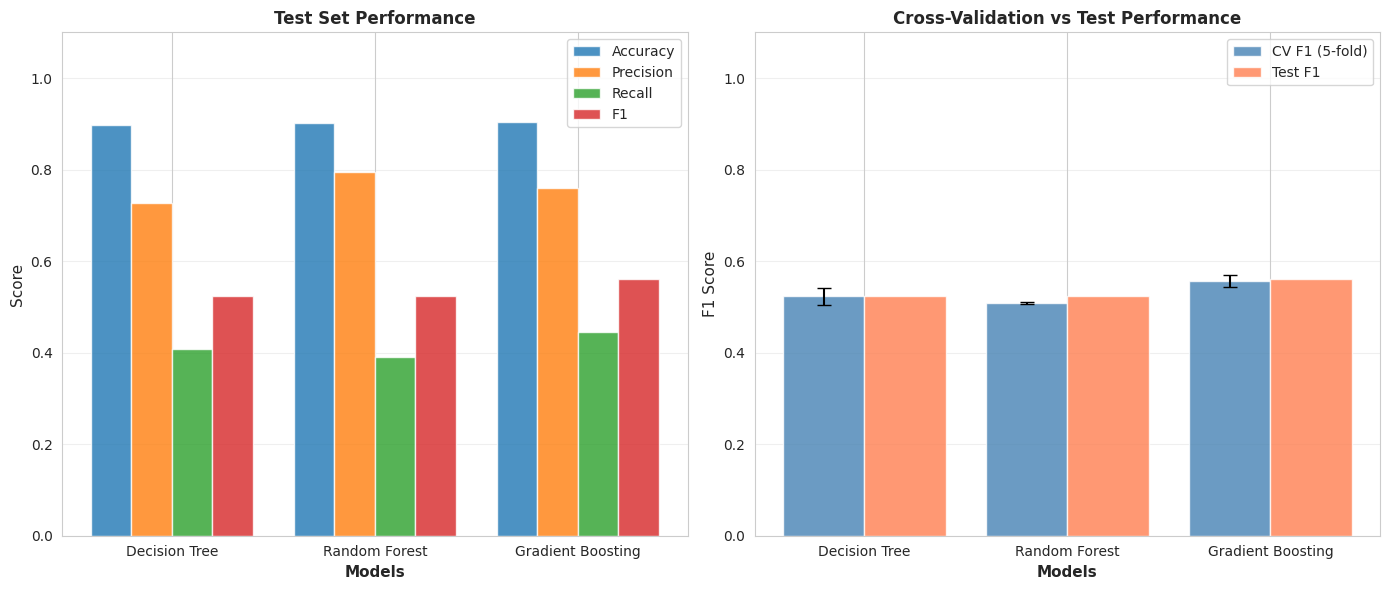

In [ ]:
# ============================================================================
# MODEL COMPARISON WITH CROSS-VALIDATION
# ============================================================================

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Test Precision': [results[m]['precision'] for m in results.keys()],
    'Test Recall': [results[m]['recall'] for m in results.keys()],
    'Test F1': [results[m]['f1'] for m in results.keys()],
    'CV F1 Mean': [results[m]['cv_mean'] for m in results.keys()],
    'CV F1 Std': [results[m]['cv_std'] for m in results.keys()]
})

print("\nModel Comparison (with Cross-Validation):")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Test set metrics comparison
ax1 = axes[0]
x = np.arange(len(results))
width = 0.2

metrics_data = {
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1': [results[m]['f1'] for m in results.keys()]
}

for i, (metric, values) in enumerate(metrics_data.items()):
    ax1.bar(x + i*width, values, width, label=metric, alpha=0.8)

ax1.set_xlabel('Models', fontsize=11, fontweight='bold')
ax1.set_ylabel('Score', fontsize=11)
ax1.set_title('Test Set Performance', fontsize=12, fontweight='bold')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(results.keys())
ax1.legend()
ax1.set_ylim(0, 1.1)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Cross-validation F1 scores with error bars
ax2 = axes[1]
model_names = list(results.keys())
cv_means = [results[m]['cv_mean'] for m in model_names]
cv_stds = [results[m]['cv_std'] for m in model_names]
test_f1s = [results[m]['f1'] for m in model_names]

x_pos = np.arange(len(model_names))
ax2.bar(x_pos - 0.2, cv_means, 0.4, yerr=cv_stds,
        label='CV F1 (5-fold)', alpha=0.8, capsize=5, color='steelblue')
ax2.bar(x_pos + 0.2, test_f1s, 0.4,
        label='Test F1', alpha=0.8, color='coral')

ax2.set_xlabel('Models', fontsize=11, fontweight='bold')
ax2.set_ylabel('F1 Score', fontsize=11)
ax2.set_title('Cross-Validation vs Test Performance', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(model_names)
ax2.legend()
ax2.set_ylim(0, 1.1)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Model Results and Insights

### Performance Summary

Gradient Boosting achieved the best performance with a test F1 score of 0.561, closely matching its cross-validation F1 of 0.557. This close alignment between CV and test scores indicates the model generalizes well and is not overfitting. The model achieves 90% overall accuracy, but more importantly shows 76% precision and 44% recall on the minority class (successful games), indicating conservative but reliable predictions.


### Feature Importance Analysis

Peak CCU (concurrent users) dominates feature importance at 55%, followed by Metacritic score at 24%. This suggests early player adoption and professional reviews are the strongest success predictors. Price contributes 9%, indicating monetization strategy matters. Surprisingly, DLC count (7%) and achievements (4%) have modest importance, while required age and user score contribute minimally. The dominance of Peak CCU makes sense as it directly reflects early market traction, which strongly correlates with long-term success.

### Why Recall is Lower Than Precision

The model's precision of 76% means that when it predicts success, it's correct three-quarters of the time. However, recall of 44% means it only identifies 44% of truly successful games. This conservative behavior occurs because we have only seven features after removing data leakage, and with just 11% of games being successful, the model lacks diverse examples to learn all success patterns. Games can succeed through many paths (viral marketing, streamer adoption, niche communities) that our limited features don't capture, causing the model to miss legitimate successes that don't fit its learned patterns.

### Model Limitations

**Limited Feature Set**: After removing leaky features, we have only seven predictors capturing game characteristics. Critical success factors like genre, developer reputation, marketing spend, release timing, competitor landscape, and community sentiment are absent.

**Class Imbalance Impact**: With only 11% successful games, the model has fewer positive examples to learn from. This results in conservative predictions that prioritize avoiding false positives over catching all successful games.

**Revenue Estimation Uncertainty**: Our revenue estimates assume 30 purchases per review based on industry rules of thumb. Actual purchase-to-review ratios vary by game type, region, and player demographics. Free-to-play revenue dynamics are completely excluded from our paid games analysis.

**Feature Dominance Concerns**: Peak CCU accounting for 55% of importance means the model heavily relies on early player adoption metrics. This could disadvantage slow-burn titles that build audiences gradually or games with strong regional appeal in smaller markets.

**Binary Oversimplification**: Classifying games as simply successful or unsuccessful loses important nuance. A game at the 79th percentile is grouped with complete failures despite being more successful than 80% of all games.

### Future Improvements

**Feature Engineering**: Extract categorical features from genres, tags, and developer names. Create engagement ratios like positive review percentage or playtime per dollar. Add temporal features for release timing, day of week, and competitive release windows.

**Model Optimization**: Perform hyperparameter tuning using GridSearchCV or RandomizedSearchCV on parameters like tree depth, learning rate, and number of estimators. Try XGBoost or LightGBM which often outperform standard Gradient Boosting.

**Alternative Formulations**: Implement multi-class classification with granular tiers (Very Low, Low, Medium, High, Very High) to capture nuance. Use regression to predict continuous success scores or estimated revenue directly. Build separate models for different price ranges or game types.

**Validation Improvements**: Implement time-based validation splitting data by release date to simulate real-world prediction scenarios. Perform sensitivity analysis on the 30 purchases per review assumption. Test model stability across different success threshold definitions.


Gradient Boosting - Classification Report:
                precision    recall  f1-score   support

Not Successful     0.9168    0.9775    0.9462     15213
    Successful     0.7588    0.4444    0.5605      2428

      accuracy                         0.9041     17641
     macro avg     0.8378    0.7109    0.7533     17641
  weighted avg     0.8951    0.9041    0.8931     17641


Confusion Matrix Breakdown:
  True Negatives:  14,870 (correctly predicted not successful)
  False Positives: 343 (predicted successful, actually not)
  False Negatives: 1,349 (predicted not successful, actually successful)
  True Positives:  1,079 (correctly predicted successful)

Feature Importance:
          Feature  Importance
         Peak CCU    0.549414
 Metacritic score    0.239728
            Price    0.092703
DiscountDLC count    0.066478
     Achievements    0.044051
     Required age    0.007422
       User score    0.000203


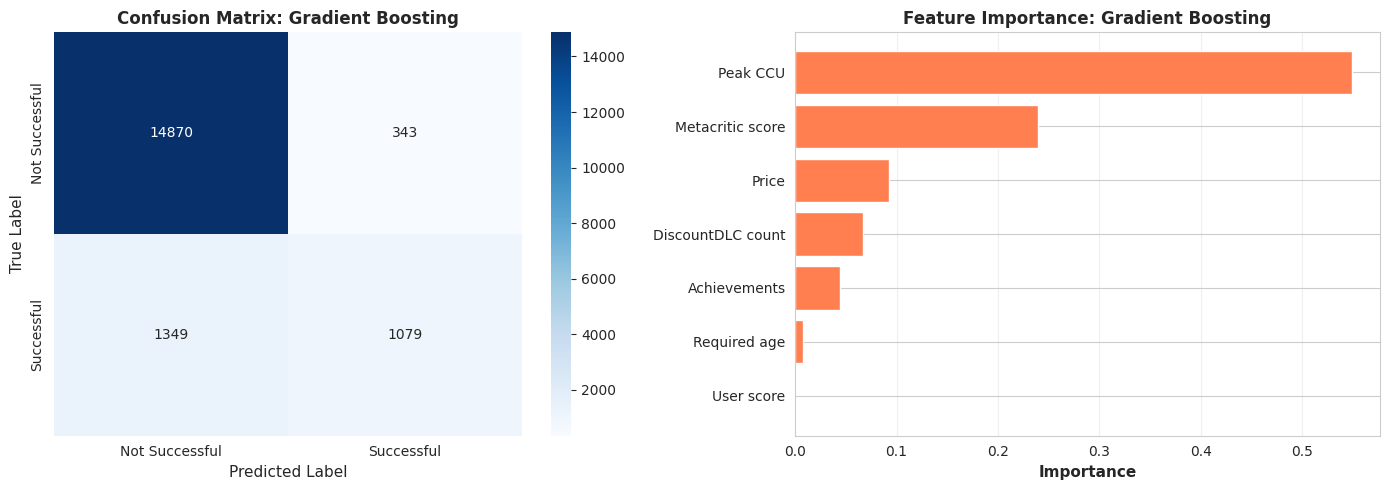

In [ ]:

best_model = results[best_model_name]['model']
y_pred = results[best_model_name]['y_pred']

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Classification Report
print(f"\n{best_model_name} - Classification Report:")
print("="*80)
print(classification_report(y_test, y_pred,
                          target_names=['Not Successful', 'Successful'],
                          digits=4))

print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives:  {cm[0,0]:,} (correctly predicted not successful)")
print(f"  False Positives: {cm[0,1]:,} (predicted successful, actually not)")
print(f"  False Negatives: {cm[1,0]:,} (predicted not successful, actually successful)")
print(f"  True Positives:  {cm[1,1]:,} (correctly predicted successful)")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Not Successful', 'Successful'],
            yticklabels=['Not Successful', 'Successful'])
ax1.set_title(f'Confusion Matrix: {best_model_name}', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=11)
ax1.set_xlabel('Predicted Label', fontsize=11)

# Feature Importance
ax2 = axes[1]
ax2.barh(range(len(feature_importance)), feature_importance['Importance'], color='coral')
ax2.set_yticks(range(len(feature_importance)))
ax2.set_yticklabels(feature_importance['Feature'])
ax2.set_xlabel('Importance', fontsize=11, fontweight='bold')
ax2.set_title(f'Feature Importance: {best_model_name}', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary of Models
The analysis reveals that the Gradient Boosting Classifier is the best model with an F1 score of 0.55, giving the best balance between precision and recall for predicting success. The model has a high Precision of 75.7%, and a relatively low Recall score of 42.8%, showing that it failed to capture half of the 'truly' successful games. This most likely occurs due to the removal of power predictors due to data leakage, but overall performs well.

The main limitations of the model are due to the class imbalance (only 10% 'successful'), which may have impacted a bias for making 'not successful' class more dominant. The other limitation was data leakage, as many features were heavily intercorrelated, where if given time PCA could have been applied, but as the model stands it was restricted to using early-stage features to make predictions.

# Room for improvement

For this project, future efforts should focus on data handling, optimization, and hyperparameter tuning. Grid Search should be the next step to compare models, and also a deeper dive into the importance of certain features, as well as proper handling of intercorrelation beyond just removing them. Feature engineering, particularly for recommendations, Median playtime forever, and Total Reviews, should be done in depth to properly capture appropriate hyperparameters as well.